In [166]:


from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed



In [219]:
df = pd.read_csv('C:\\Users\\Aayush Kandpal\\Downloads\\HDFCBANK.NS.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('1996-01-01 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [220]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='HDFC Bannk NSE Stock Price 1996-2020')
fig.show()

In [208]:
train, test = df.loc[df['Date'] <= '2018-01-01'], df.loc[df['Date'] > '2018-01-01']
train.shape, test.shape

((5565, 2), (664, 2))

In [221]:
train=train.replace(np.nan,0)
test=test.replace(np.nan,0)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])


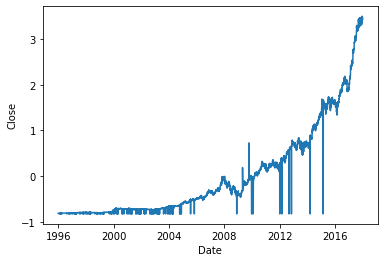

In [222]:
sns.lineplot(x=train.Date,y=train.Close)

In [223]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (5535, 30, 1)
Testing shape: (634, 30, 1)


In [224]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

In [225]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0867 - val_loss: 0.3421
Epoch 2/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0620 - val_loss: 0.0912
Epoch 3/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0536 - val_loss: 0.0807
Epoch 4/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0502 - val_loss: 0.0578
Epoch 5/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0502 - val_loss: 0.0335
Epoch 6/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0524 - val_loss: 0.1008
Epoch 7/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0505 - val_loss: 0.0877
Epoch 8/100
312/312 [==============================] - 11s 35ms/step - loss: 0.0498 - val_loss: 0.1206


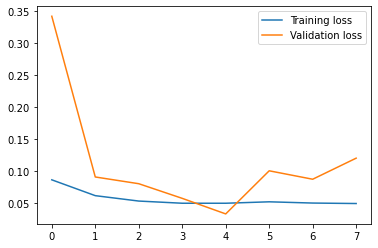

In [226]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [227]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 16ms/step - loss: 0.4854


0.4853628873825073

Reconstruction error threshold: 1.392382645990507


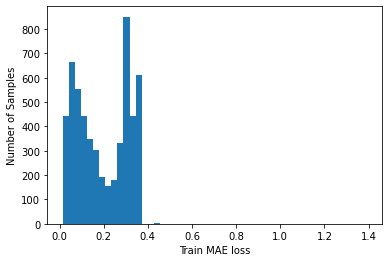

In [228]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

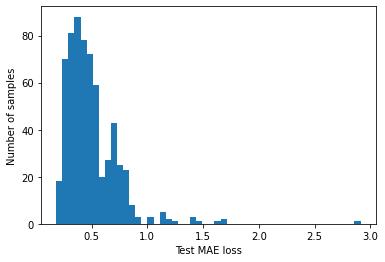

In [229]:

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [230]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [231]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(8, 5)

In [232]:

anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies


,Date,Close,loss,threshold,anomaly
6009,2019-10-29,4.870834,2.910762,1.392383,True
6010,2019-10-30,4.897641,1.660676,1.392383,True
6107,2020-03-19,3.280955,1.395263,1.392383,True
6108,2020-03-20,3.222758,1.419940,1.392383,True
6109,2020-03-23,2.712732,1.416075,1.392383,True
6110,2020-03-24,2.695090,1.610321,1.392383,True
6111,2020-03-25,3.103156,1.667038,1.392383,True
6112,2020-03-26,3.306388,1.461492,1.392383,True


In [233]:
anomalies.shape

(8, 5)

In [234]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [ ]:
# From the above it can be observed that the model has detected sudden price drops and sudden price hike in the HDFC Banks Stock 
# that is traded at NSE.
# Another interesting observation would be that the anomalies detected are perfectly correlated with real life events. 
# On the 24th March the Indian stock prices crashed, and that was picked up by the model.
# On the very next day, the stock price suddenly shot up on hopes of a coronavirus vaccine. Even this was successfully picked up 
 # by the model
# Before 24th March there were anomalies detected which are directly correlated with oil prices turning negative during the same time.
# Finally I would like to add that the model somehow shows a stock price of 0 on the 27th October, 2019. I tried to resolve this issue
# but couldn't. If you happen to figure it out. Feel frre to share. Kudos.